In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from tqdm import tqdm

In [2]:
import load_script

In [3]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [4]:
train_dataset,target=load_script.load_dataset(train=True)

In [5]:
test_dataset,test_target=load_script.load_dataset(train=False)

In [6]:
target=target.long()
test_target=test_target.long()

# Added modules

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class Tensor4D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],1,*input.shape[1:])

In [9]:
class Tensor3D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],input.shape[1],-1)

# Normalization

In [10]:
train_dataset.mean(0)

Variable containing:
 7.3101e+01  7.3109e+01  7.2001e+01  ...   6.4324e+01  6.5037e+01  6.5048e+01
 5.0706e+00  5.9728e+00  4.1829e+00  ...  -3.1212e+00 -2.7500e+00 -2.3117e+00
 5.3022e+01  5.3706e+01  5.2293e+01  ...   4.5319e+01  4.5553e+01  4.6292e+01
                ...                   ⋱                   ...                
 1.3597e+01  1.3734e+01  1.3298e+01  ...   1.0306e+01  1.0556e+01  1.0504e+01
 2.3973e+01  2.3983e+01  2.2980e+01  ...   2.2531e+01  2.2226e+01  2.2265e+01
 9.5851e+00  9.5892e+00  8.4953e+00  ...   8.9079e+00  9.0392e+00  8.8203e+00
[torch.FloatTensor of size 28x50]

In [11]:
mean=train_dataset.mean(0).view(1,28,-1)
std=train_dataset.std(0).view(1,28,-1)

In [12]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Single output

In [13]:
class SingleOutput(nn.Module):
    def __init__(self):
        super(SingleOutput,self).__init__()

        self.conv1=nn.Conv1d(28,14,5)
        self.full1=nn.Linear(14*46,100)
        self.full2=nn.Linear(100,1)
        
    def forward(self,x):
        x=F.max_pool1d(F.relu(self.conv1(x)),1)
        x=x.view(-1)
        x=F.relu(self.full1(x.view(-1,14*46)))
        x=F.sigmoid(self.full2(x))
        
        return x

### Sequential

In [14]:
# 50 -> 48 -> 24 -> 20 -> 10

In [15]:
class Sequential(nn.Module):
    def __init__(self):
        super(Sequential,self).__init__()
        
        layers=[]
        layers.append(nn.Conv1d(28,28,3))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        layers.append(nn.Conv1d(28,28,5))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        layers.append(nn.Conv1d(28,28,5))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        layers.append(Flatten())
        layers.append(nn.Linear(28*3,200))
        layers.append(nn.ReLU())
#         layers.append(nn.Linear(200,20))
#         layers.append(nn.ReLU())
        layers.append(nn.Linear(200,2))
#         layers.append(nn.Sigmoid())
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

### Convolution 2d

In [16]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D,self).__init__()
        
        # 28*50
        layers=[]
        layers.append(nn.Conv1d(28,28,3))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        
        # Dropout
        layers.append(nn.Dropout(0.8))
        
        # 28*24
        layers.append(nn.Conv1d(28,28,5))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        
        # Dropout
        layers.append(nn.Dropout(0.8))
        
        # 28*10
        layers.append(Tensor4D())
        layers.append(nn.Conv2d(1,10,5))
        # 10*24*6
        layers.append(Tensor3D())
        # 10*144
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(2))
        # 10*72
        
        # Dropout
        layers.append(nn.Dropout(0.8))
        
        layers.append(Flatten())
        layers.append(nn.Linear(10*72,200))
        layers.append(nn.ReLU())
        
        # Dropout
        layers.append(nn.Dropout(0.8))
        
        layers.append(nn.Linear(200,20))
        layers.append(nn.ReLU())
        
        # Dropout
        layers.append(nn.Dropout(0.8))
        
        layers.append(nn.Linear(20,2))        
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

### Simple Network

In [17]:
class MyConv1D:
    def __init__(self,input_channels,output_channels,kernel,dropout_rate=0.8):
        self.conv=nn.Conv1d(input_channels,output_channels,kernel)
        self.relu=nn.ReLU()
        self.batch_norm=nn.BatchNorm1d(output_channels)
        self.dropout=nn.Dropout(dropout_rate)
        self._layers=[self.conv,self.relu,self.batch_norm,self.dropout]
    
    @property
    def layers(self):
        return self._layers

In [18]:
class Simple(nn.Module):
    def __init__(self):
        super(Simple,self).__init__()
        
        layers=[]
        layers+=MyConv1D(28,28,3,0.8).layers
#         layers+=MyConv1D(28,28,5,0.8).layers
#         layers+=MyConv1D(28,28,5,0.8).layers
        
        layers.append(Flatten())
        layers.append(nn.Linear(28*48,200))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(200,2))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

In [19]:
def train_network(network,optimizer,verbose=False):
    
    criterion=nn.CrossEntropyLoss()
    mini_batch_size=79

    errors_test=[]
    for epoch in range(1001):

        total_loss=0
        output_target=torch.zeros(target.shape[0])
        for b in range(0,train_dataset.shape[0],mini_batch_size):


            train_element=train_dataset.narrow(0,b,mini_batch_size)

            target_element=target.narrow(0,b,mini_batch_size)

            optimizer.zero_grad()


            out=net(train_element)
            output_target[b:b+mini_batch_size]=(out[:,1]>out[:,0]).data

            loss=criterion(out,target_element)
            loss.backward()
            optimizer.step()
            total_loss+=loss.data[0]

        output_test=torch.zeros(test_target.shape[0])
        out=net(test_dataset)
        output_test=(out[:,1]>out[:,0]).data.long()


    #     print(type(output_test))

        error_train=np.sum(list(output_target.long()==target.data))/target.shape[0]
        error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
        errors_test.append(error_test)
        if epoch%10==0 and verbose:
            print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
                 'Correct test:',str(error_test*100)[:5]+"%")
        if error_train>0.995:# or (epoch>80 and np.abs(np.mean(errors_test[-80:])-np.mean(errors_test[-25:]))<0.01):
            return epoch,np.max(errors_test)
        
    return epoch,np.max(errors_test)

In [25]:
class Train:
    
    def __init__(self,network,optimizer,verbose=False,weights_initialization=0.01,
                mini_batch_size=79,
                criterion=nn.CrossEntropyLoss(),
                max_epoch=1000,
                randomize_training_dataset=True,plot=False):
        self.network=network
        self.optimizer=optimizer
        self.verbose=verbose
        self.weights_initialization=weights_initialization
        self.criterion=criterion
        self.mini_batch_size=mini_batch_size
        self.max_epoch=max_epoch
        self.randomize_training_dataset=randomize_training_dataset
        self.plot=plot
        
    def __call__(self,repetitions=5):
        epochs=[]
        errors=[]
        for i in range(repetitions):
            for param in net.parameters():
                param.data.normal_(0, self.weights_initialization)
            print('Repetition',i)
            epoch,error=self.train_network(self.network,self.optimizer,verbose=self.verbose,plot=self.plot)
            epochs.append(epoch)
            errors.append(error)
        
        return epochs,errors
    
    
    def train_network(self,network,optimizer,randomize_training_dataset=True,
                      verbose=False,plot=False):
    
        errors_train=[]
        errors_test=[]
        for epoch in tqdm(range(self.max_epoch)):
            if self.randomize_training_dataset:
                random_permutation=torch.randperm(train_dataset.shape[0])
            else:
                random_permutation=torch.arange(train_dataset.shape[0])
                
            train_dataset_shuffled=train_dataset[random_permutation]
            target_shuffled=target[random_permutation]
            total_loss,output_target=self.run_epoch(train_dataset_shuffled,target_shuffled)
#             total_loss,output_target=self.run_epoch(train_dataset,target)

            output_test=torch.zeros(test_target.shape[0])
            out=net(test_dataset)
            output_test=(out[:,1]>out[:,0]).data.long()



            error_train=np.sum(list(output_target.long()==target_shuffled.data))/target.shape[0]
            error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
            errors_train.append(error_train)
            errors_test.append(error_test)
            
            if epoch%10==0 and verbose:
                print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
                     'Correct test:',str(error_test*100)[:5]+"%")
                
#             if error_train>0.995:# or (epoch>150 and np.abs(np.mean(errors_train[-80:])-np.mean(errors_train[-25:]))<0.005):
#                 return epoch,np.max(errors_test)
        if plot:
            
            print('Performance:',np.mean(errors_test[300:]))
            plt.plot(list(range(epoch+1)),errors_train,label='Errors train')
            plt.plot(list(range(epoch+1)) ,errors_test,label='Errors test')
            
            plt.legend()
            plt.show()
                 
        return epoch,np.max(errors_test)
    
    def run_epoch(self,train_dataset,target):
        total_loss=0
        output_target=torch.zeros(target.shape[0])
        
        for b in range(0,train_dataset.shape[0],self.mini_batch_size):

            train_element=train_dataset.narrow(0,b,self.mini_batch_size)
            target_element=target.narrow(0,b,self.mini_batch_size)

            self.optimizer.zero_grad()

            out=net(train_element)
            output_target[b:b+self.mini_batch_size]=(out[:,1]>out[:,0]).data

            loss=self.criterion(out,target_element)
            loss.backward()
            self.optimizer.step()
            total_loss+=loss.data[0]
            
        return total_loss,output_target

  0%|          | 2/1000 [00:00<00:54, 18.17it/s]

Weight 0.02
Repetition 0


100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]


Performance: 0.747985714286


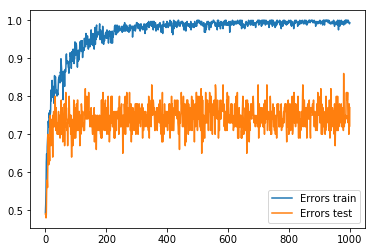

  0%|          | 3/1000 [00:00<00:47, 21.15it/s]

Repetition 1


100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


Performance: 0.718585714286


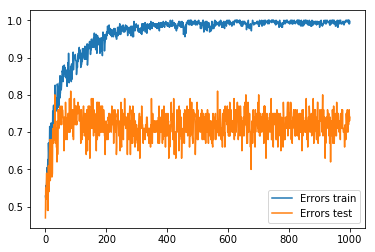

  0%|          | 0/1000 [00:00<?, ?it/s]

Repetition 2


 75%|███████▍  | 746/1000 [00:36<00:12, 20.33it/s]

In [ ]:
net=Simple()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0)

weight_dict={}
for weight in [0.02]:
    print('Weight',weight)
    train=Train(net,optimizer,weights_initialization=weight,verbose=False,plot=True,max_epoch=1000)
    
    weight_dict[weight]=train()
    print(weight_dict[weight])


In [15]:
net=CNN2D()

optimizer = optim.SGD(net.parameters(), lr=1)
optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=0)


criterion=nn.CrossEntropyLoss()
mini_batch_size=79

for epoch in range(1001):
    
    total_loss=0
    output_target=torch.zeros(target.shape[0])
    for b in range(0,train_dataset.shape[0],mini_batch_size):
        
        
        train_element=train_dataset.narrow(0,b,mini_batch_size)
#         train_element=train_element.view(1,28,-1)
        
        target_element=target.narrow(0,b,mini_batch_size)
        
        optimizer.zero_grad()
        

        out=net(train_element)
        output_target[b:b+mini_batch_size]=(out[:,1]>out[:,0]).data
        
        loss=criterion(out,target_element)
        loss.backward()
        optimizer.step()
        total_loss+=loss.data[0]
        
    output_test=torch.zeros(test_target.shape[0])
    out=net(test_dataset)
    output_test=(out[:,1]>out[:,0]).data.long()
        
    
#     print(type(output_test))
        
    error_train=np.sum(list(output_target.long()==target.data))/target.shape[0]
    error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
    if epoch%10==0:
        print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
             'Correct test:',str(error_test*100)[:5]+"%")

Epoch: 0 Loss: 2.826216459274292 Correct: 41.77% Correct test: 53.0%
Epoch: 10 Loss: 2.613489508628845 Correct: 65.50% Correct test: 52.0%
Epoch: 20 Loss: 2.4392541646957397 Correct: 69.93% Correct test: 56.0%
Epoch: 30 Loss: 2.2193009853363037 Correct: 74.05% Correct test: 55.0%
Epoch: 40 Loss: 1.9510942995548248 Correct: 78.79% Correct test: 57.0%
Epoch: 50 Loss: 1.6690470576286316 Correct: 83.54% Correct test: 61.0%
Epoch: 60 Loss: 1.3851625621318817 Correct: 87.65% Correct test: 58.0%
Epoch: 70 Loss: 1.115644097328186 Correct: 91.77% Correct test: 57.0%
Epoch: 80 Loss: 0.8598392009735107 Correct: 94.62% Correct test: 57.0%
Epoch: 90 Loss: 0.6713583469390869 Correct: 95.56% Correct test: 55.0%
Epoch: 100 Loss: 0.5844872444868088 Correct: 95.88% Correct test: 57.0%
Epoch: 110 Loss: 0.36556436121463776 Correct: 99.05% Correct test: 61.0%
Epoch: 120 Loss: 0.2529432997107506 Correct: 99.68% Correct test: 62.0%
Epoch: 130 Loss: 0.193000216037035 Correct: 100.0% Correct test: 62.0%
Epoch:

KeyboardInterrupt: 

In [ ]:
79*720

In [105]:
360*200

72000